In [1]:
import mne
import pandas as pd 
import re #regex library to format fast to read into pd 
import os
import neurokit2 as nk 
import matplotlib.pyplot as plt
import feather 
import numpy as np
import platform
from files_in_out import getListOfFiles,GetFiles
from markers_DF import get_DF_centerd,get_help_DF


In [2]:

if platform.system()=='Darwin':
    os.chdir('/Users/leupinv/switchdrive/BBC/WP1/data/EEG/tsk/')

else:
    os.chdir('c:/Users/Engi/all/BBC/WP1/data/EEG/tsk')

In [3]:
g_num='g45'
eeg_format='fif'
eeg_exp='tsk'
datafolder='raw'

#files = getListOfFiles(datafolder,g_num)

files = GetFiles(datafolder,g_num,eeg_format=eeg_format)

taskfiles=files.taskfiles
taskfiles

['raw\\g45\\g45_n_tsk_1_ds_eeg.fif', 'raw\\g45\\g45_n_tsk_3_ds_eeg.fif']

In [4]:
files.get_info(index=1)

dir_tsk=files.current_file_dir
dir_tsk

'raw\\g45\\g45_n_tsk_3_ds_eeg.fif'

In [5]:
#%cd /Users/leupinv/switchdrive/BBC/WP1/data/EEG/tsk/raw/g01/ 
raw=mne.io.read_raw_fif(dir_tsk,preload=True)
raw.info

Opening raw data file raw\g45\g45_n_tsk_3_ds_eeg.fif...
    Range : 0 ... 387071 =      0.000 ...  1511.996 secs
Ready.
Reading 0 ... 387071  =      0.000 ...  1511.996 secs...


<Info | 11 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 128 EEG, 1 ECG, 1 RESP, 1 STIM
 custom_ref_applied: True
 dig: 131 items (3 Cardinal, 128 EEG)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 lowpass: 40.0 Hz
 meas_date: 2021-05-23 11:37:29 UTC
 meas_id: 4 items (dict)
 nchan: 131
 projs: []
 sfreq: 256.0 Hz
>

In [6]:
events_from_annot, event_dict = mne.events_from_annotations(raw)

Used Annotations descriptions: ['hep/R/exh/CA/RRCA', 'hep/R/exh/CU/RRCU', 'hep/R/inh/CA/RRCA', 'hep/R/inh/CU/RRCU', 'hep/R2/exh/CA/RRCA', 'hep/R2/exh/CU/RRCU', 'hep/R2/inh/CA/RRCA', 'hep/R2/inh/CU/RRCU', 'hep/T/exh/CA/no_val', 'hep/T/exh/CU/no_val', 'hep/T/inh/CA/no_val', 'hep/T/inh/CU/no_val', 'hep/T2/exh/CA/no_val', 'hep/T2/exh/CU/no_val', 'hep/T2/inh/CA/no_val', 'hep/T2/inh/CU/no_val', 'vep/CA/dia/exh', 'vep/CA/dia/inh', 'vep/CA/sys/exh', 'vep/CA/sys/inh', 'vep/CU/dia/exh', 'vep/CU/dia/inh', 'vep/CU/sys/exh', 'vep/CU/sys/inh']


# ECG test ICA
- identify component
    - compare fitting on epoched data and continous data 
- remove component
- test effect of the removal on boh hep and vep
- epoching should be done separately on cleaned and not cleand data set 

In [7]:
from mne.preprocessing import ICA
# Choose other parameters
 # if float, select n_components by explained variance of PCA
 # we need sufficient statistics, not all time points -> saves time
random_state = 23

In [ ]:
#ICA on continuous data + EOG rej
ica = ICA(random_state=random_state)
print(ica)
ica.fit(raw)
print(ica)

In [ ]:
eog_epochs=mne.preprocessing.create_eog_epochs(raw,ch_name='C16',baseline=(-0.5,-0.2))
eog_inds, scores = ica.find_bads_eog(eog_epochs,ch_name='C16')  # find via correlati
ica.plot_overlay(eog_epochs.average(), exclude=eog_inds, show=False)
# red -> before, black -> after. Yes! We remove quite a lot!

# to definitely register this component as a bad one to be removed
# there is the ``ica.exclude`` attribute, a simple Python list
ica.exclude.extend(eog_inds)

In [ ]:
eog_inds

In [ ]:

reconst_raw_eog = raw.copy()

ica.apply(reconst_raw_eog)

In [8]:
TF=[tf[0] for  tf in events_from_annot]
tf=pd.Series(TF)
tf[tf.duplicated()]


686    382071
dtype: int64

In [9]:
dup=tf[tf.duplicated()]
dup=dup.index
dup=dup[0]

In [10]:
events_from_annot[dup][0]+=1

In [11]:
tmin, tmax = -0.2, 0.7
baseline = (None)

picks = mne.pick_types(raw.info, meg=False, eeg=True)
epochs_raw = mne.Epochs(raw, events_from_annot, event_dict, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=None,                 
                    preload=True)

Not setting metadata
Not setting metadata
702 matching events found
No baseline correction applied
0 projection items activated
Loading data for 702 events and 231 original time points ...
0 bad epochs dropped


In [ ]:
tmin, tmax = -0.2, 0.7
baseline = (None)

picks = mne.pick_types(reconst_raw_eog.info, meg=False, eeg=True)
epochs_raw_eog = mne.Epochs(reconst_raw_eog, events_from_annot, event_dict, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=None,                 
                    preload=True)

In [ ]:
from mne.preprocessing import create_ecg_epochs
ecg_epochs=create_ecg_epochs(raw)
ecg_evoked = ecg_epochs.average()

In [ ]:
ecg_epochs

In [ ]:
# find ECG component


ecg_indices, ecg_scores = ica.find_bads_ecg(raw, method='correlation',
                                            threshold='auto')

In [ ]:
ecg_indices

In [ ]:
ica.plot_scores(ecg_scores)

# plot diagnostics
ica.plot_properties(ecg_epochs, picks=ecg_indices)

# plot ICs applied to raw data, with ECG matches highlighted
ica.plot_sources(ecg_epochs, show_scrollbars=False)



In [ ]:
%matplotlib qt
ica.plot_sources(raw)



In [ ]:
# plot diagnostics
erp_axis=np.array([-1,1])
ica.plot_properties(ecg_epochs, picks=11)

In [ ]:
%matplotlib auto
# plot ICs applied to the averaged ECG epochs, with ECG matches highlighted
ica.plot_sources(ecg_evoked)

In [ ]:
ica.exclude=[]
ica.exclude.extend([0,1,10])

In [ ]:
reconst_raw_ecg = raw.copy()

ica.apply(reconst_raw_ecg)

In [ ]:
tmin, tmax = -0.2, 0.7
baseline = (None)

picks = mne.pick_types(reconst_raw_ecg.info, meg=False, eeg=True)
epochs_remove_ecg = mne.Epochs(reconst_raw_ecg, events_from_annot, event_dict, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=None,                 
                    preload=True)

In [ ]:
# compute the same for ICA fitted on epchs isntead of continuos data 
ica_ecg = ICA(random_state=random_state,method='picard')
ica_ecg.fit(ecg_epochs)


In [ ]:
ica_ecg_decim = ICA(random_state=random_state,method='picard')
ica_ecg_decim.fit(ecg_epochs,decim=4)


In [ ]:
ecg_indices_decim, ecg_scores_decim = ica_ecg_decim.find_bads_ecg(ecg_epochs, method='correlation',
                                            threshold='auto')


In [ ]:
ica_ecg_decim.plot_properties(ecg_epochs, picks=ecg_indices_decim)

In [ ]:
ecg_indices, ecg_scores = ica_ecg.find_bads_ecg(ecg_epochs, method='correlation',
                                            threshold='auto')
ica_ecg.plot_scores(ecg_scores)

# plot diagnostics
ica_ecg.plot_properties(ecg_epochs, picks=ecg_indices)

# plot ICs applied to raw data, with ECG matches highlighted
ica_ecg.plot_sources(ecg_epochs)

# plot ICs applied to the averaged ECG epochs, with ECG matches highlighted
ica_ecg.plot_sources(ecg_evoked)

In [ ]:
ica_ecg.plot_sources(ecg_evoked,picks=18)

In [ ]:
ica_ecg.plot_sources(ecg_epochs)

In [ ]:
ica.plot_properties(ecg_epochs, picks=18)

In [ ]:
ica.plot_overlay(epochs_raw['vep/CA'].average(), exclude=[0], show=True)

In [ ]:
ica.plot_sources(raw)

In [ ]:
ica.exclude=[]
ica_ecg.exclude=[]

In [ ]:
epochs_raw['hep/CA'].average().plot()

In [ ]:
ica_ecg_decim.exclude=[]
ica_ecg.exclude=[]
ica_ecg_decim.plot_overlay(epochs_raw['hep/R2/CA'].average(), exclude=[0,1], show=True)
ica_ecg_decim.exclude=[]
ica_ecg.exclude=[]
ica_ecg_decim.plot_overlay(epochs_raw['hep/R2/CA'].average(), exclude=[0,1,11], show=True)
ica_ecg_decim.exclude=[]
ica_ecg.exclude=[]
ica_ecg.plot_overlay(epochs_raw['hep/R2/CA'].average(), exclude=[0,1], show=True)
ica_ecg_decim.exclude=[]
ica_ecg.exclude=[]
ica_ecg.plot_overlay(epochs_raw['hep/R2/CA'].average(), exclude=[0,1,12], show=True)
ica_ecg_decim.exclude=[]
ica_ecg.exclude=[]

In [ ]:
#evoked response HEP with and without ICA +EOG component 
ica.exclude=[]
ica_ecg.exclude=[]
ica.plot_overlay(epochs_raw['hep/R2/CA'].average(), exclude=[0,1], show=True)
ica.exclude=[]
ica_ecg.exclude=[]
ica.plot_overlay(epochs_raw['hep/R2/CA'].average(), exclude=[0,1,10], show=True)
ica.exclude=[]
ica_ecg.exclude=[]
ica_ecg.plot_overlay(epochs_raw['hep/R2/CA'].average(), exclude=[0,1], show=True)
ica.exclude=[]
ica_ecg.exclude=[]
ica_ecg.plot_overlay(epochs_raw['hep/R2/CA'].average(), exclude=[0,1,12], show=True)
ica.exclude=[]
ica_ecg.exclude=[]


In [ ]:
ica.exclude=[]

ica.plot_overlay(epochs_raw['vep/CA'].average(), exclude=[0,1], show=True)
ica.exclude=[]

ica.plot_overlay(epochs_raw['vep/CA'].average(), exclude=[0,1,10], show=True)
ica.exclude=[]

In [ ]:
#evoked response HEP with and without ICA +EOG component 
ica.exclude=[]
ica_ecg.exclude=[]
ica.plot_overlay(epochs_raw['vep/CA'].average(), exclude=[0], show=True)
ica.exclude=[]
ica_ecg.exclude=[]
ica.plot_overlay(epochs_raw['vep/CA'].average(), exclude=[0,1], show=True)
ica.exclude=[]
ica_ecg.exclude=[]
ica.plot_overlay(epochs_raw['vep/CA'].average(), exclude=[0,1,10], show=True)
ica.exclude=[]
ica_ecg.exclude=[]
ica_ecg.plot_overlay(epochs_raw['vep/CA'].average(), exclude=[0,1], show=True)
ica.exclude=[]
ica_ecg.exclude=[]
ica_ecg.plot_overlay(epochs_raw['vep/CA'].average(), exclude=[0,1,10], show=True)
ica.exclude=[]
ica_ecg.exclude=[]

In [ ]:
ica_ecg_decim.exclude=[]
ica_ecg.exclude=[]
ica_ecg_decim.plot_overlay(epochs_raw['vep/CA'].average(), exclude=[0,1], show=True)
ica_ecg_decim.exclude=[]
ica_ecg.exclude=[]
ica_ecg_decim.plot_overlay(epochs_raw['vep/CA'].average(), exclude=[0,1,11], show=True)
ica_ecg_decim.exclude=[]
ica_ecg.exclude=[]
ica_ecg.plot_overlay(epochs_raw['vep/CA'].average(), exclude=[0,1], show=True)
ica_ecg_decim.exclude=[]
ica_ecg.exclude=[]
ica_ecg.plot_overlay(epochs_raw['vep/CA'].average(), exclude=[0,1,12], show=True)
ica_ecg_decim.exclude=[]
ica_ecg.exclude=[]

In [ ]:
epochs_raw['vep/CA'].average().plot_joint()
epochs_remove_ecg ['vep/CA'].average().plot_joint()

In [ ]:
epochs_raw_eog['hep/R2/CA'].average().plot(spatial_colors=True)
epochs_remove_ecg ['hep/R2/CA'].average().plot(spatial_colors=True)

# Do ICA over epoched

In [33]:
ica_epoch=ICA(random_state=random_state)
print(ica)
ica_epoch.fit(epochs_raw)
print(ica)

<ICA | epochs decomposition, fit (fastica): 110695 samples, 127 components, channels used: "eeg">
Fitting ICA to data using 128 channels (please be patient, this may take a while)


<ipython-input-33-759016ac00cc>:1: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica_epoch=ICA(random_state=random_state)


Selecting by non-zero PCA components: 127 components
Fitting ICA took 145.4s.
<ICA | epochs decomposition, fit (fastica): 110695 samples, 127 components, channels used: "eeg">


In [34]:
picks=np.arange(0,20)

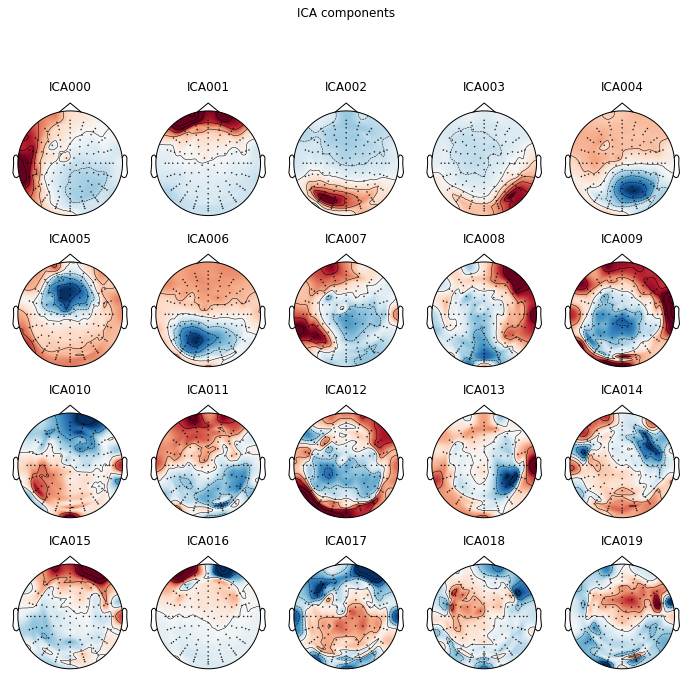

Not setting metadata
Not setting metadata
702 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


<ipython-input-35-df972bbd159f>:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  ica_epoch.plot_sources(epochs_raw)


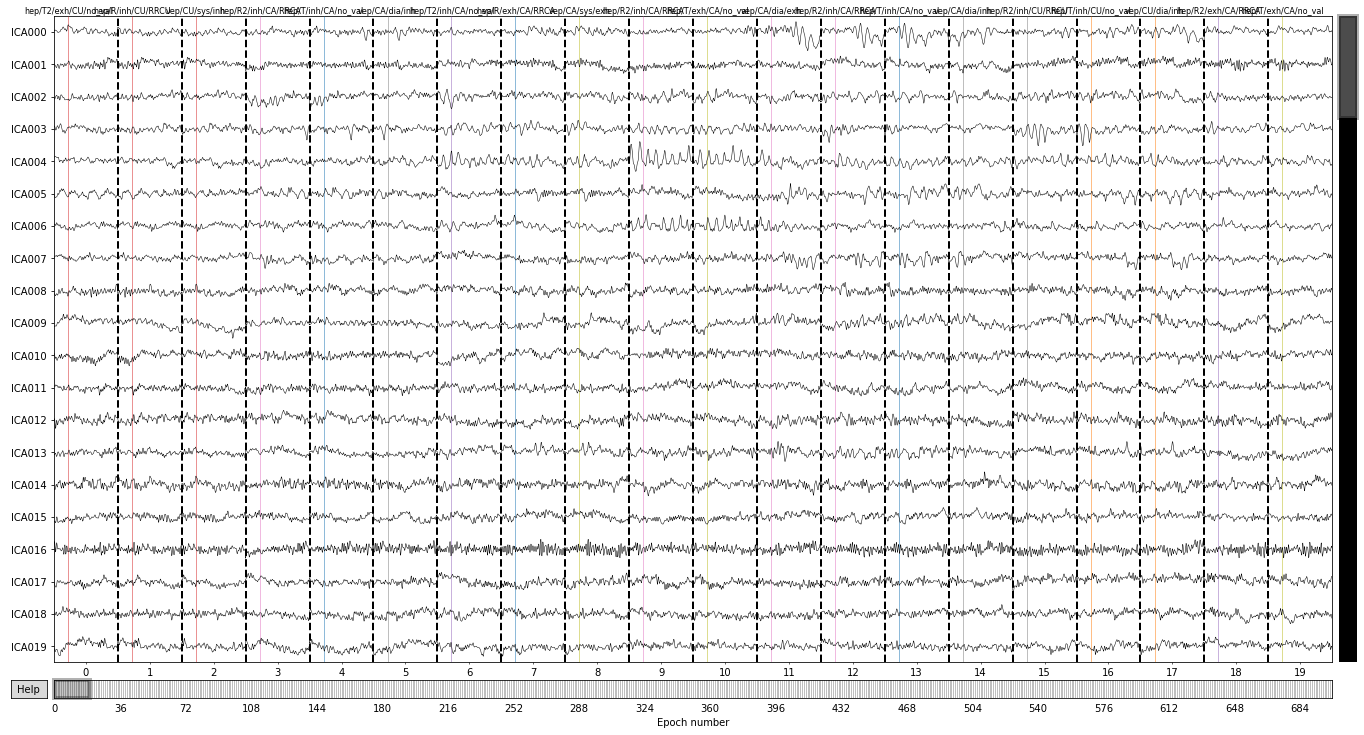

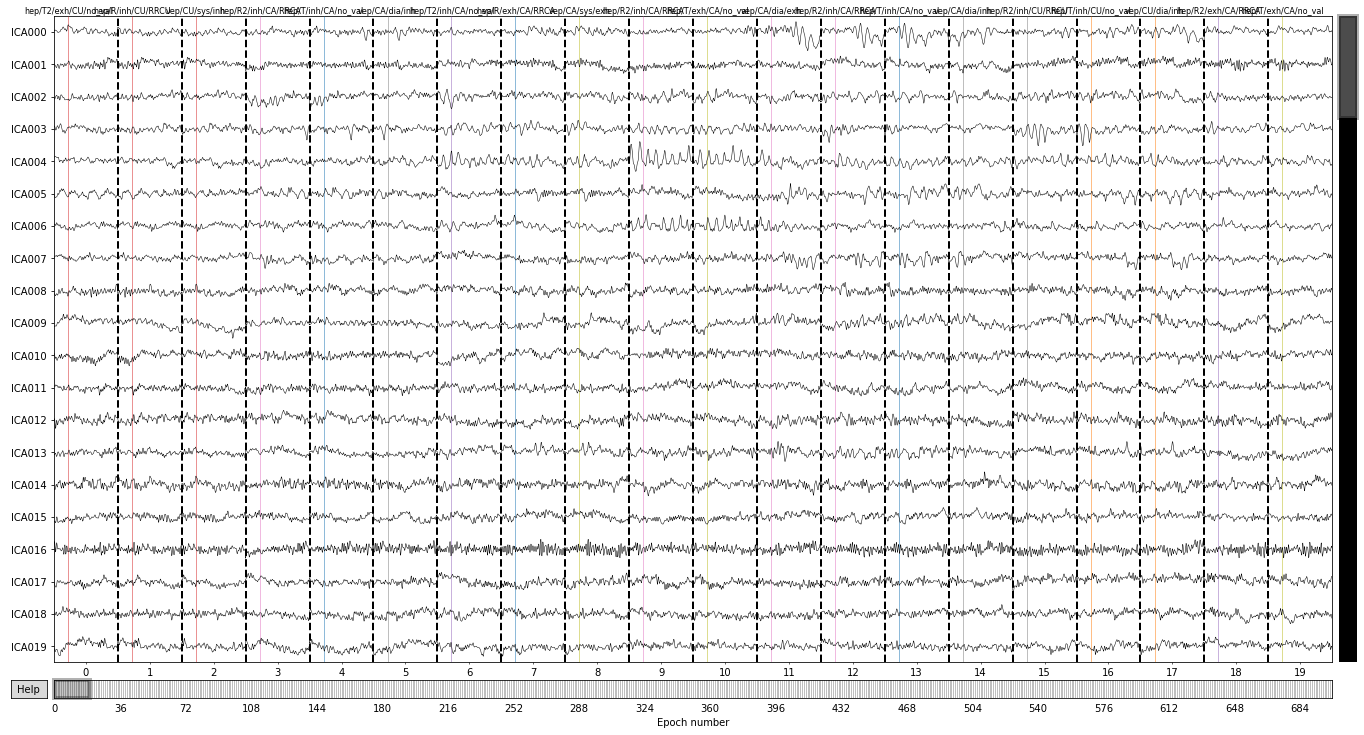

In [35]:
ica_epoch.plot_components(picks=picks)
ica_epoch.plot_sources(epochs_raw)

In [36]:
ecg_indices_epochs, ecg_scores_epochs = ica_epoch.find_bads_ecg(ecg_epochs, method='correlation',
                                            threshold='auto')

In [43]:
ica_epoch.plot_properties(ecg_epochs, picks=ecg_indices_epochs)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
1703 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[<Figure size 1400x1200 with 6 Axes>]

In [42]:
%matplotlib qt
ica_epoch.plot_propreties(ecg_epochs)


AttributeError: 'ICA' object has no attribute 'plot_proprieties'

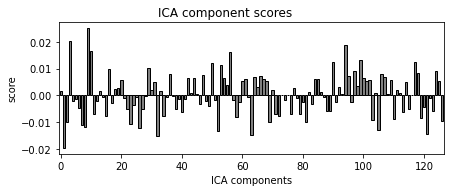

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
1703 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


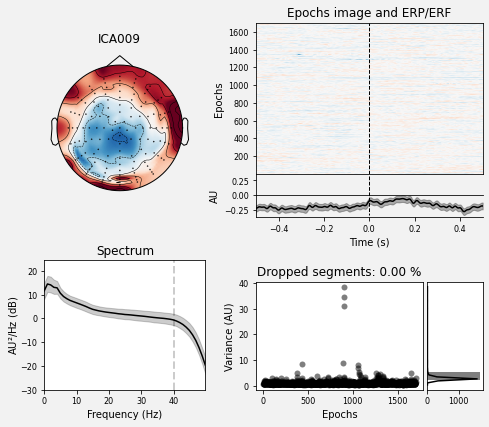

Not setting metadata
Not setting metadata
1703 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


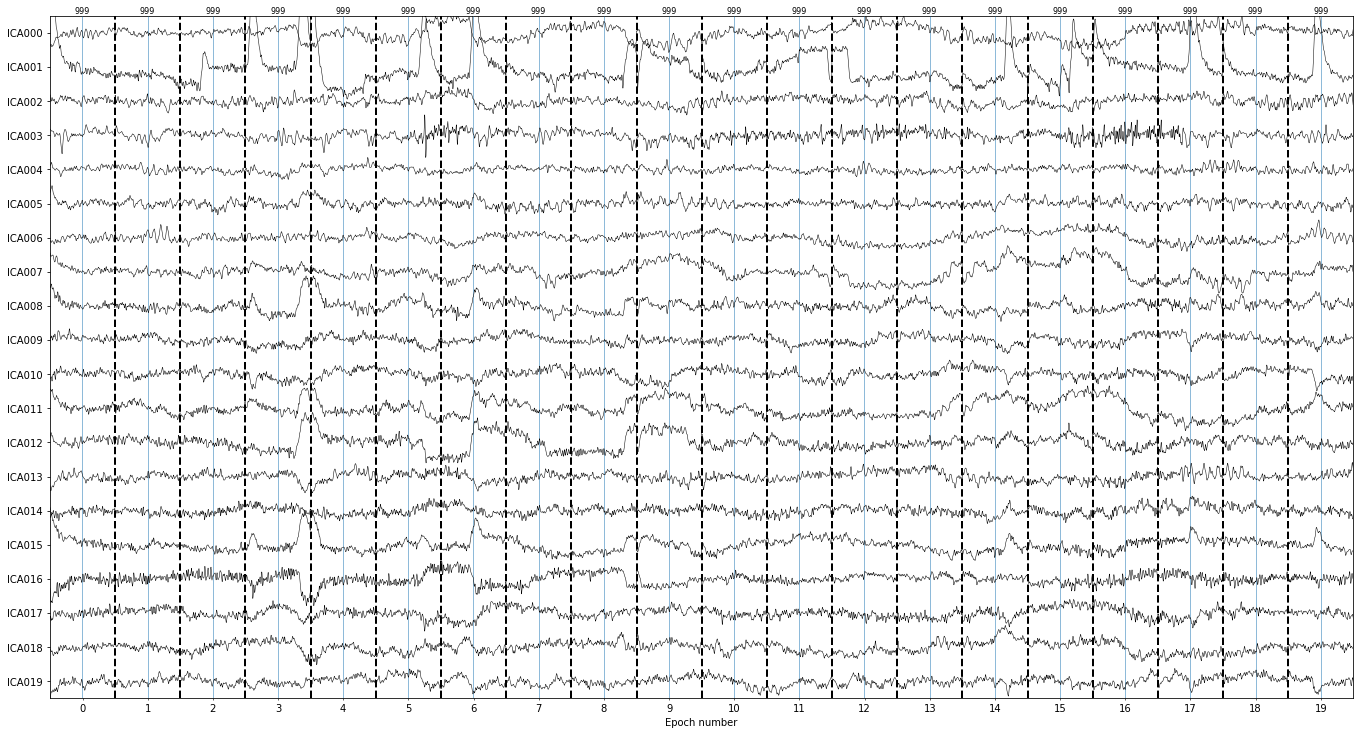

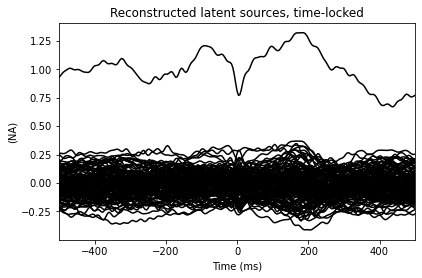

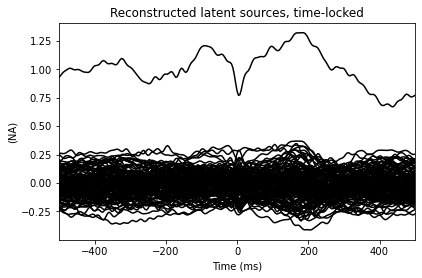

In [38]:
ica_epoch.plot_scores(ecg_scores_epochs)

# plot diagnostics
ica_epoch.plot_properties(ecg_epochs, picks=ecg_indices_epochs)

# plot ICs applied to raw data, with ECG matches highlighted
ica_epoch.plot_sources(ecg_epochs, show_scrollbars=False)

# plot ICs applied to the averaged ECG epochs, with ECG matches highlighted
ica_epoch.plot_sources(ecg_evoked)

# Picard vs fastica 

In [25]:
pica = ICA(random_state=random_state,method='picard')
print(pica)
pica.fit(ecg_epochs,decim=4)
print(pica)


<ICA | no decomposition, fit (picard):  samples, no dimension reduction>
Fitting ICA to data using 128 channels (please be patient, this may take a while)


<ipython-input-25-27b07c25f998>:1: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  pica = ICA(random_state=random_state,method='picard')


Selecting by non-zero PCA components: 127 components


C:\Users\Engi\anaconda3\envs\mne\lib\site-packages\picard\solver.py:213: UserWarning: Picard did not converge. Final gradient norm : 5.195e-05. Requested tolerance : 1e-07. Consider increasing the number of iterations or the tolerance.
  warnings.warn('Picard did not converge. Final gradient norm : %.4g.'


Fitting ICA took 135.4s.
<ICA | epochs decomposition, fit (picard): 110695 samples, 127 components, channels used: "eeg">


In [26]:

ica = ICA(random_state=random_state)
print(ica)
ica.fit(ecg_epochs,decim=4)
print(ica)

<ICA | no decomposition, fit (fastica):  samples, no dimension reduction>
Fitting ICA to data using 128 channels (please be patient, this may take a while)


<ipython-input-26-4c22bcbfdfc7>:1: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = ICA(random_state=random_state)


Selecting by non-zero PCA components: 127 components


C:\Users\Engi\anaconda3\envs\mne\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Fitting ICA took 96.0s.
<ICA | epochs decomposition, fit (fastica): 110695 samples, 127 components, channels used: "eeg">


In [17]:
from mne.preprocessing import create_ecg_epochs
ecg_epochs=create_ecg_epochs(raw)
ecg_evoked = ecg_epochs.average()

Using channel EXG1 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2560 samples (10.000 sec)

Number of ECG events detected : 1704 (average pulse 67 / min.)
Not setting metadata
Not setting metadata
1704 matching events found
No baseline correction applied
Loading data for 1704 events and 257 original time points ...
1 bad epochs dropped


In [27]:
ecg_indices_pica, ecg_scores_pica = pica.find_bads_ecg(ecg_epochs, method='correlation',
                                            threshold='auto')

In [28]:
ecg_indices_ica, ecg_scores_ica = ica.find_bads_ecg(ecg_epochs, method='correlation',
                                            threshold='auto')

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
1703 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1703 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1703 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


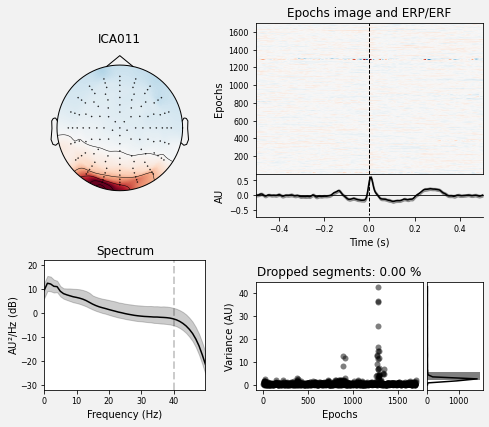

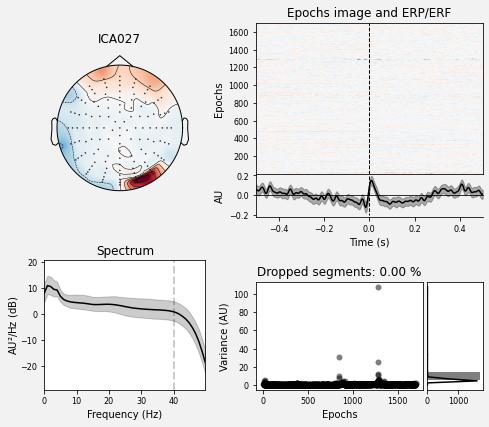

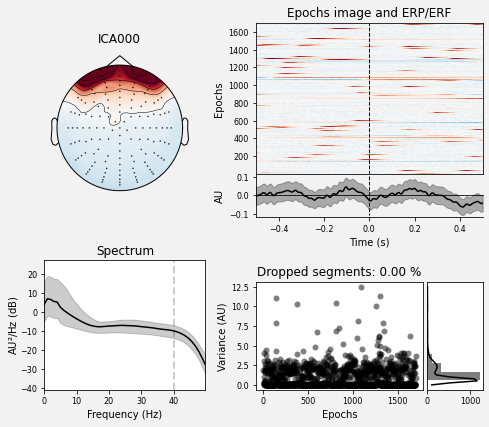

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [29]:
pica.plot_properties(ecg_epochs, picks=ecg_indices_pica)
#ecg indice=11

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
1703 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1703 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1703 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1703 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


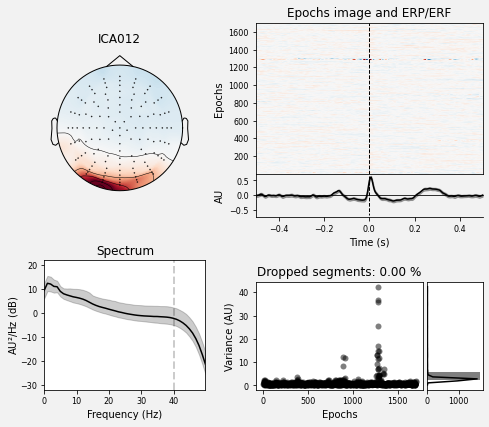

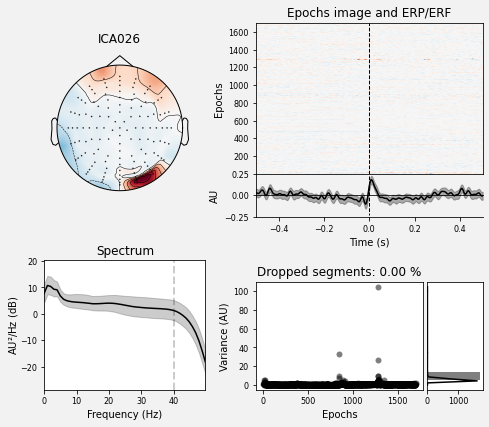

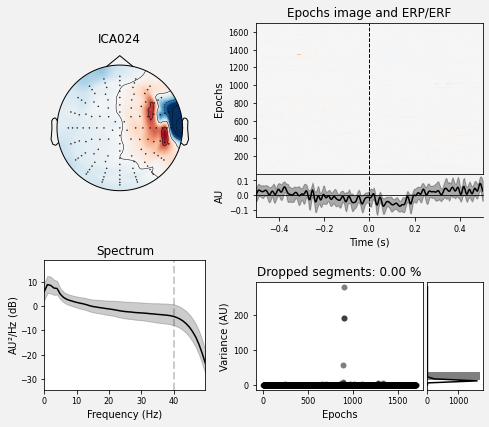

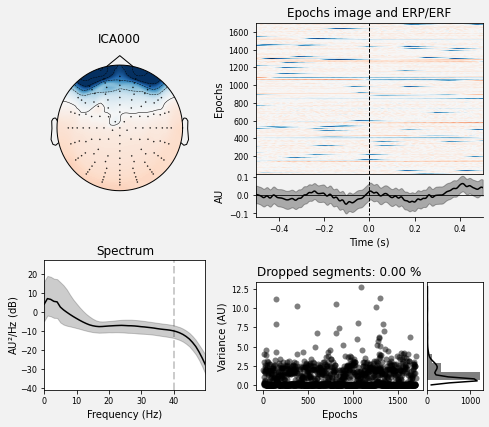

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [30]:
ica.plot_properties(ecg_epochs, picks=ecg_indices_ica)
#ecg indice=12

Applying ICA to Evoked instance
    Transforming to ICA space (127 components)
    Zeroing out 2 ICA components
    Projecting back using 128 PCA components


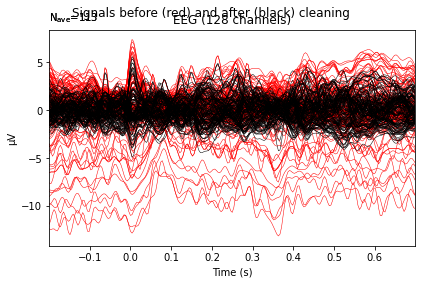

Applying ICA to Evoked instance
    Transforming to ICA space (127 components)
    Zeroing out 3 ICA components
    Projecting back using 128 PCA components


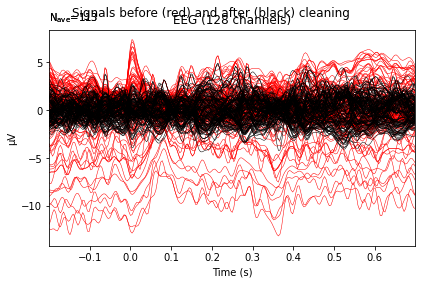

Applying ICA to Evoked instance
    Transforming to ICA space (127 components)
    Zeroing out 2 ICA components
    Projecting back using 128 PCA components


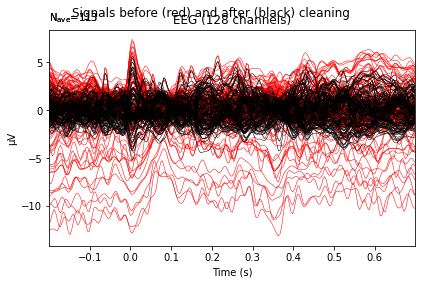

Applying ICA to Evoked instance
    Transforming to ICA space (127 components)
    Zeroing out 3 ICA components
    Projecting back using 128 PCA components


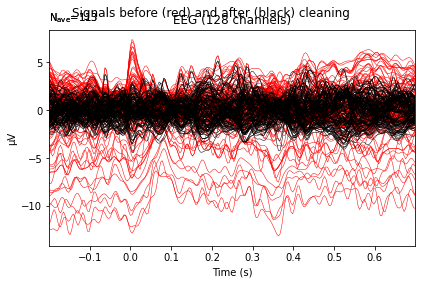

In [31]:
pica.exclude=[]
ica.exclude=[]
pica.plot_overlay(epochs_raw['hep/R2/CA'].average(), exclude=[0,1], show=True)
pica.exclude=[]
ica.exclude=[]
pica.plot_overlay(epochs_raw['hep/R2/CA'].average(), exclude=[0,1,11], show=True)
pica.exclude=[]
ica.exclude=[]
ica.plot_overlay(epochs_raw['hep/R2/CA'].average(), exclude=[0,1], show=True)
pica.exclude=[]
ica.exclude=[]
ica.plot_overlay(epochs_raw['hep/R2/CA'].average(), exclude=[0,1,12], show=True)
pica.exclude=[]
ica.exclude=[]

Applying ICA to Evoked instance
    Transforming to ICA space (127 components)
    Zeroing out 2 ICA components
    Projecting back using 128 PCA components


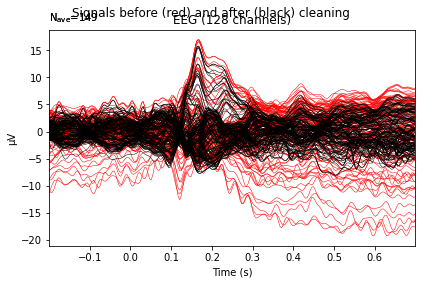

Applying ICA to Evoked instance
    Transforming to ICA space (127 components)
    Zeroing out 2 ICA components
    Projecting back using 128 PCA components


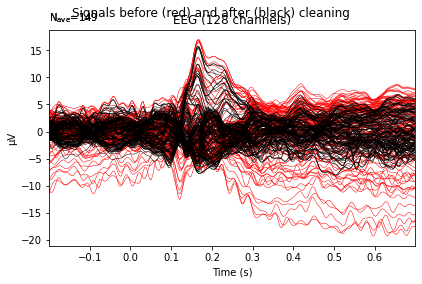

Applying ICA to Evoked instance
    Transforming to ICA space (127 components)
    Zeroing out 3 ICA components
    Projecting back using 128 PCA components


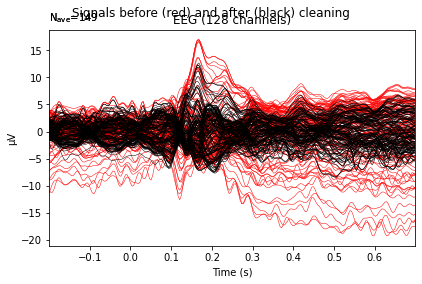

Applying ICA to Evoked instance
    Transforming to ICA space (127 components)
    Zeroing out 3 ICA components
    Projecting back using 128 PCA components


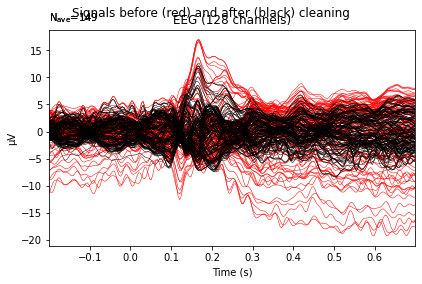

In [32]:
pica.exclude=[]
ica.exclude=[]
pica.plot_overlay(epochs_raw['vep/CA'].average(), exclude=[0,1], show=True)
pica.exclude=[]
ica.exclude=[]
ica.plot_overlay(epochs_raw['vep/CA'].average(), exclude=[0,1], show=True)
pica.exclude=[]
ica.exclude=[]
pica.plot_overlay(epochs_raw['vep/CA'].average(), exclude=[0,1,11], show=True)
pica.exclude=[]
ica.exclude=[]

ica.plot_overlay(epochs_raw['vep/CA'].average(), exclude=[0,1,12], show=True)
pica.exclude=[]
ica.exclude=[]

In [47]:
ica.plot_overlay(epochs_raw['vep/CA'].average(), exclude=[0,1], show=True)
pica.exclude=[]
ica.exclude=[]
ica.plot_overlay(epochs_raw['vep/sys'].average(), exclude=[0,1,12], show=True)
pica.exclude=[]
ica.exclude=[]
ica.plot_overlay(epochs_raw['vep/dia'].average(), exclude=[0,1,12], show=True)
pica.exclude=[]
ica.exclude=[]

Applying ICA to Evoked instance
    Transforming to ICA space (127 components)
    Zeroing out 2 ICA components
    Projecting back using 128 PCA components
Applying ICA to Evoked instance
    Transforming to ICA space (127 components)
    Zeroing out 3 ICA components
    Projecting back using 128 PCA components
Applying ICA to Evoked instance
    Transforming to ICA space (127 components)
    Zeroing out 3 ICA components
    Projecting back using 128 PCA components


# Try with SSP

In [ ]:
from mne.preprocessing import compute_proj_ecg
projs, events = compute_proj_ecg(raw, n_eeg=1, reject=None)

In [ ]:
ecg_projs = projs

mne.viz.plot_projs_topomap(ecg_projs, info=raw.info)

In [ ]:
raw_proj=raw.copy()

In [ ]:
raw_proj.add_proj(ecg_projs)

In [ ]:
tmin, tmax = -0.2, 0.7
baseline = (None)

picks = mne.pick_types(raw_proj.info, meg=False, eeg=True)
epochs_raw_proj = mne.Epochs(raw_proj, events_from_annot, event_dict, tmin, tmax,
                    picks=picks, baseline=baseline, reject=None,                 
                    preload=True)

In [ ]:
epochs_raw_proj['hep/R2/CA'].average().plot(proj=True,spatial_colors=True)
epochs_raw_proj['hep/R2/CA'].average().plot(proj=False,spatial_colors=True)

In [ ]:
epochs_raw_proj['vep/CA'].average().plot(proj=True)
epochs_raw_proj['vep/CA'].average().plot(proj=False)